# Tensor Robust Principal Component Analysis

**Published**: December 14, 2019

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the repository of [**tensor-learning**](https://github.com/xinychen/tensor-learning/blob/master/content/TRPCA.ipynb).

This post focuses on introducing Tensor Robust Principal Component Analysis (TRPCA) and implementing it. TRPCA is from

> Canyi Lu, Jiashi Feng, Yudong Chen, Wei Liu, Zhouchen Lin, Shuicheng Yan, 2016. Tensor Robust Principal Component Analysis: Exact Recovery of Corrupted Low-Rank Tensors via Convex Optimization. CVPR 2016. [[**PDF**](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Lu_Tensor_Robust_Principal_CVPR_2016_paper.pdf)] [[**Matlab code**](https://github.com/canyilu/Tensor-Robust-Principal-Component-Analysis-TRPCA)]

## Model Formulation

Suppose a third-order tensor $\boldsymbol{\mathcal{Y}}\in\mathbb{R}^{n_1\times n_2\times n_3}$ such that $\boldsymbol{\mathcal{Y}}=\boldsymbol{\mathcal{L}}_{0}+\boldsymbol{\mathcal{S}}_{0}$, where $\boldsymbol{\mathcal{L}}_0$ has low tubal rank and $\boldsymbol{\mathcal{S}}_0$ is sparse. Under certain suitable situations, it is possible to recover both the low-rank and the sparse components exactly by simply solving a convex optimization problem whose objective function is a weighted combination of the tensor nuclear norm and $\ell_1$-norm, i.e.,
\begin{equation}
\min _{\boldsymbol{\mathcal{X}}, \boldsymbol{\mathcal{E}}}\alpha\|\boldsymbol{\mathcal{X}}\|_{*}+\beta\|\boldsymbol{\mathcal{E}}\|_{1}, \text { s.t. } \mathcal{P}_{\Omega}(\boldsymbol{\mathcal{Y}})=\mathcal{P}_{\Omega}(\boldsymbol{\mathcal{X}}+\boldsymbol{\mathcal{E}}),
\end{equation}
where $\beta=\alpha / \sqrt{\max \left(n_{1}, n_{2}\right) n_{3}}$.

In [1]:
import numpy as np

def svt(mat, tau):
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = s - tau
    vec[vec < 0] = 0
    return np.matmul(np.matmul(u, np.diag(vec)), v)

In [2]:
def shrinkage(var, tau):
    var1 = var - tau
    var1[var1 < 0] = 0
    var2 = var + tau
    var2[var2 > 0] = 0
    return var1 + var2

In [3]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [4]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

In [5]:
def trpca(dense_tensor, sparse_tensor, alpha, beta, rho, maxiter):
    
    dim1, dim2, dim3 = sparse_tensor.shape
    dim = np.array([dim1, dim2, dim3])
    pos_train = np.where(sparse_tensor != 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[pos_train] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, len(dim))) # \boldsymbol{\mathcal{X}}
    E = np.zeros((dim1, dim2, dim3, len(dim))) # \boldsymbol{\mathcal{X}}
    Z = np.zeros((dim1, dim2, dim3, len(dim))) # \boldsymbol{\mathcal{Z}}
    T = np.zeros((dim1, dim2, dim3, len(dim))) # \boldsymbol{\mathcal{T}}
    rse = np.zeros(maxiter)
    for it in range(maxiter):
        for k in range(len(dim)):
            Z[:, :, :, k] = tensor_hat
            X[:, :, :, k] = mat2ten(svt(ten2mat(Z[:, :, :, k] - E[:, :, :, k] 
                                                + T[:, :, :, k] / rho, k), alpha / rho), dim, k)
        E = shrinkage(Z - X + T / rho, beta / rho)
        Z = X + E - T / rho
        for k in range(len(dim)):
            Z[:, :, :, k][pos_train] = sparse_tensor[pos_train]
        T = T + rho * (Z - X - E)
        tensor_hat = np.mean(Z, axis = 3)
        tensor_hat[np.where(tensor_hat > 255)] = 255
        tensor_hat[np.where(tensor_hat < 0)] = 0
        rse[it] = (np.linalg.norm(np.round(tensor_hat[pos_test]) - np.round(dense_tensor[pos_test]), 2) 
                   / np.linalg.norm(np.round(dense_tensor[pos_test]), 2))
        if (it + 1) % 20 == 0:
            print('Iter: {}'.format(it + 1))
            print('RMSE: {:.6}'.format(rse[it]))
            print()
        
    return np.mean(X, axis = 3), np.mean(E, axis = 3), np.mean(Z, axis = 3), rse

In [6]:
import imageio

name0 = ["lena"]
name = ["lena_mar"]
image = imageio.imread('../datasets/color-images/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('../datasets/color-images/{}.bmp'.format(name[0]))

In [7]:
import matplotlib.pyplot as plt

alpha = 200
rho = 1.01
dim1, dim2, dim3 = sparse_image.shape
beta = alpha / np.sqrt(max(dim1, dim2) * dim3)
maxiter = 200
X, E, Z, rse = trpca(image, sparse_image, alpha, beta, rho, maxiter)

Iter: 20
RMSE: 0.601765

Iter: 40
RMSE: 0.328215

Iter: 60
RMSE: 0.206133

Iter: 80
RMSE: 0.170293

Iter: 100
RMSE: 0.160053

Iter: 120
RMSE: 0.156438

Iter: 140
RMSE: 0.154997

Iter: 160
RMSE: 0.15437

Iter: 180
RMSE: 0.154088

Iter: 200
RMSE: 0.153959



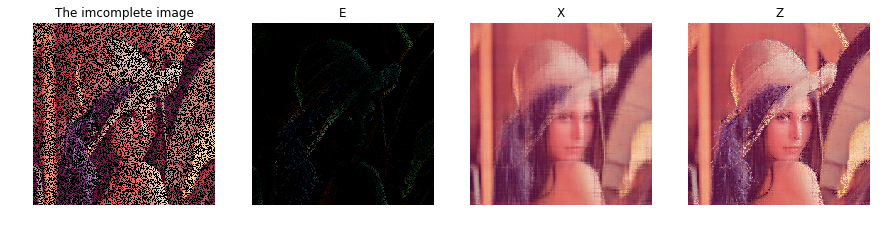

In [8]:
plt.subplots(1, 4, figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

sparse = np.round(E).astype(int)
sparse[np.where(sparse > 255)] = 255
sparse[np.where(sparse < 0)] = 0
plt.subplot(1, 4, 2)
plt.imshow(sparse)
plt.title('E')
plt.axis('off')

dense = np.round(X).astype(int)
dense[np.where(dense > 255)] = 255
dense[np.where(dense < 0)] = 0
plt.subplot(1, 4, 3)
plt.imshow(dense)
plt.title('X')
plt.axis('off')

image_rec = np.round(Z).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
plt.subplot(1, 4, 4)
plt.imshow(image_rec)
plt.title('Z')
plt.axis('off')
plt.show()